## Worksheet 2

### Group 22 Eaton Heidegger and Shannon Schröder

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import time
import PIL

## Exercise 1: Complexity of alogrithms

In [3]:
# Numpy DFT

def DFT_numpy(f):
    N = f.shape[0]
    n = np.arange(N)
    m = n.reshape((N, 1))

    F = np.exp(-1j * 2 * np.pi * m * n / N)

    return np.dot(F, f)

This is a **direct implementation of the Discrete Fourier Transform (DFT)** using matrix multiplication and broadcasting:
- `m * n / N` creates a matrix of all \( k \cdot n \) combinations.
- `F` is the full **DFT matrix**, with complex exponential values (the Fourier kernel).
- The matrix `F` is then **multiplied with the input vector** `f` using `np.dot(F, f)` to compute all DFT coefficients at once.


- Very concise and leverages NumPy’s matrix operations.
- Computationally expensive for large inputs: **O(N²)** time complexity.
- Memory-intensive, because it builds a full \( N \times N \) matrix in memory.


In [4]:
# Numba DFT

@numba.njit(parallel=True)
def DFT_numba(f):
    N = f.shape[0]
    fhat = np.zeros(N, dtype=np.complex128)

    for k in numba.prange(N):
        for n in range(N):
            fhat[k] += f[n] * np.exp(-1j * 2 * np.pi * k * n / N)
    return fhat

This is a **loop-based implementation** of the DFT, accelerated with **Numba**:
- For each output frequency index \( k \), it sums over the input signal `f[n]` multiplied by the Fourier kernel \( \exp(-2\pi i k n / N) \).
- The outer loop is parallelized using `numba.prange()` to compute different frequency bins concurrently.

- Same mathematical result as the NumPy DFT.
- Much **faster for large N** than the NumPy version, thanks to JIT compilation and parallelization.
- Still **O(N²)** in time complexity, just optimized.


In [5]:
# FFT

def FFT(f):
    N = f.shape[0]
    if N == 1:
        return f.astype(np.complex128)
    # else:
    fhat = np.zeros(N, dtype=np.complex128)
    fhat_even = FFT(f[::2])
    fhat_odd = FFT(f[1::2])
    omegaN = np.exp(-2j * np.pi / N)
    z = 1
    for m in range(N // 2):
        fhat[m] = fhat_even[m] + z * fhat_odd[m]
        fhat[m + N // 2] = fhat_even[m] - z * fhat_odd[m]
        z *= omegaN
    return fhat


This is a **recursive implementation of the Cooley-Tukey FFT algorithm**, which dramatically reduces computation time:
- The input signal is **recursively split into even and odd-indexed parts**.
- These are transformed separately (divide-and-conquer strategy).
- Results are combined using the so-called **twiddle factors** $\omega_N^m$, which are complex exponentials.
- The combination step uses the symmetry and periodicity properties of the Fourier kernel to reuse computations.

- Much **faster**: **O(N log N)** time complexity — ideal for large inputs.
- Foundation for all fast Fourier methods used in practice.
- Requires \( N \) to be a power of 2 for this recursive version to work efficiently.
- Recursive implementation may be slower than NumPy's built-in `np.fft.fft()` for very large N due to Python recursion limits and overhead.


### 1.1 Test the correctness of your implementation by making sure that they all return the same transformed data, and that all agree with numpy.fft.fft

In [6]:
# Test data
N = 1024
f = np.random.rand(N) + 1j * np.random.rand(N)

# Compute implementations
fhat_numpy = DFT_numpy(f)
fhat_numba = DFT_numba(f)
fhat_fft = FFT(f)
fhat_np_fft = np.fft.fft(f)

# Check if the results are the same
print("DFT_numpy correct:", np.allclose(fhat_numpy, fhat_np_fft, atol=1e-6))
print("DFT_numba correct:", np.allclose(fhat_numba, fhat_np_fft, atol=1e-6))
print("FFT correct:", np.allclose(fhat_fft, fhat_np_fft, atol=1e-6))

# Check if results match each other 
print("DFT_numpy vs DFT_numba:", np.allclose(fhat_numpy, fhat_numba, atol=1e-6))
print("DFT_numpy vs FFT:", np.allclose(fhat_numpy, fhat_fft, atol=1e-6))
print("DFT_numba vs FFT:", np.allclose(fhat_numba, fhat_fft, atol=1e-6))

DFT_numpy correct: True
DFT_numba correct: True
FFT correct: True
DFT_numpy vs DFT_numba: True
DFT_numpy vs FFT: True
DFT_numba vs FFT: True


To verify the correctness of our Discrete Fourier Transform (DFT) and Fast Fourier Transform (FFT) implementations, we compare their outputs against the result of NumPy’s built-in `np.fft.fft()` function, which serves as a reliable reference. Since the Fourier Transform is commonly used on complex-valued data, we generate a test input array `f` of length \( N = 1024 \) consisting of random complex numbers. This ensures that all implementations are tested under general, realistic conditions.

We then compute the transformed output using four different methods: our own matrix-based `DFT_numpy`, the loop-based and parallelized `DFT_numba`, the recursive Cooley–Tukey `FFT`, and NumPy’s `np.fft.fft`. To determine whether the results are consistent, we use NumPy’s `np.allclose()` function, which checks whether two arrays are element-wise equal within a given numerical tolerance. This is necessary because floating-point arithmetic can introduce small numerical differences, especially in complex-valued computations or recursive functions.

The comparison is done in two parts. First, we check whether each of our three implementations (`DFT_numpy`, `DFT_numba`, and `FFT`) produces results that are numerically close to NumPy's `np.fft.fft`. Then, we compare the outputs of our own implementations against each other to ensure internal consistency across different algorithmic approaches.

We chose a tolerance level of \( 10^{-6} \), which is suitable for practical purposes and accounts for small numerical inaccuracies. If all comparisons return `True`, we can conclude that the implementations are correct and consistent with each other and with the trusted NumPy FFT function. This validation gives us confidence that the mathematical logic behind all our transform functions is sound and that they are functionally equivalent.

### 1.2. For input data (of your choice, e.g. random) of different lengths N = 32, 64, 128, 256, 1024, 2048 time the runtime of the different DFT implementations and plot the runtime against N in a log-log plot. Identify which algorithms achieve O(N2) and which O(N logN) scaling?

In [7]:
def measure_time(N_values, func):
    times = []
    for N in N_values:
        f = np.random.rand(N) + 1j * np.random.rand(N)
        start = time.perf_counter()
        fhat = func(f)
        end = time.perf_counter()
        times.append(end - start)
    return times

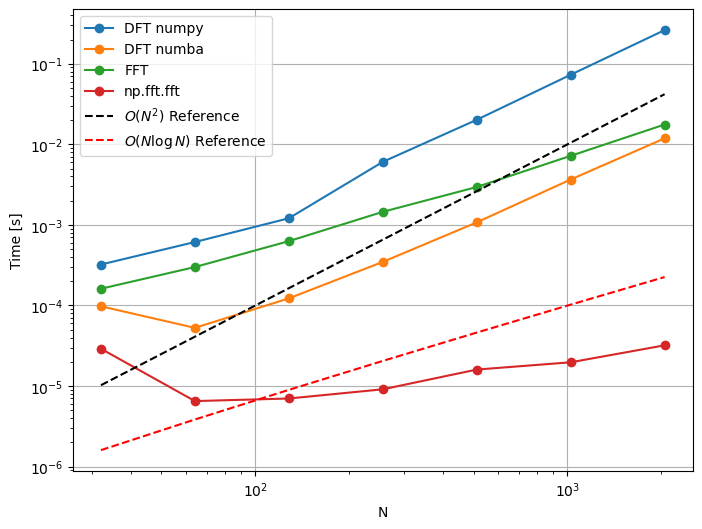

In [8]:
# Run time measurements

N_values = [32, 64, 128, 256, 512, 1024, 2048]
dft_numpy_times = []
dft_numba_times = []
fft_times = []
np_fft_times = []

dft_numpy_times = measure_time(N_values, DFT_numpy)
dft_numba_times = measure_time(N_values, DFT_numba)
fft_times = measure_time(N_values, FFT)
np_fft_times = measure_time(N_values, np.fft.fft)

plt.figure(figsize=(8, 6))
plt.loglog(N_values, dft_numpy_times, "o-", label="DFT numpy")
plt.loglog(N_values, dft_numba_times, "o-", label="DFT numba")
plt.loglog(N_values, fft_times, "o-", label="FFT")
plt.loglog(N_values, np_fft_times, "o-", label="np.fft.fft")

# Add reference lines
N_ref = np.array(N_values, dtype=np.float64)

# Reference for O(N^2)
O_N2 = 1e-8 * N_ref**2  # Scaled for visibility
plt.loglog(N_ref, O_N2, "k--", label=r"$O(N^2)$ Reference")

# Reference for O(N log N)
O_NlogN = 1e-8 * N_ref * np.log2(N_ref)  # Scaled for visibility
plt.loglog(N_ref, O_NlogN, "r--", label=r"$O(N \log N)$ Reference")



plt.xlabel("N")
plt.ylabel("Time [s]")
plt.legend()
plt.grid(True)
plt.show()



To analyze and compare the performance of different Fourier Transform implementations, we measured the **runtime** of four methods over a range of input sizes (N = 32, 64, 128, 256, 512, 1024, 2048). The goal was to experimentally identify which algorithms scale as $\mathcal{O}(N^2)$ and which scale more efficiently as $\mathcal{O}(N \log N)$, as theoretically expected.

We defined a reusable function `measure_time()` that takes a list of input sizes and a transformation function. For each N, it generates a random complex-valued input array and measures the execution time using `time.perf_counter()`. This approach ensures consistent timing across all implementations and keeps the code clean and modular. The tested functions should theoretically scale as follows:

1. **`DFT_numpy`**: a matrix-based implementation of the Discrete Fourier Transform using NumPy operations. It explicitly constructs the DFT matrix and performs a matrix-vector multiplication, which theoretically scales as $\mathcal{O}(N^2)$.
   
2. **`DFT_numba`**: a loop-based implementation of the DFT accelerated with Numba’s `@njit(parallel=True)`. It retains $\mathcal{O}(N^2)$ complexity but benefits from Just-In-Time compilation and multithreading, resulting in significantly faster performance than the NumPy version for larger N.

3. **`FFT`**: a recursive implementation of the Cooley–Tukey Fast Fourier Transform algorithm. It uses divide-and-conquer and recursive calls to break the problem into smaller subproblems, achieving the much more efficient $\mathcal{O}(N \log N)$ complexity.

4. **`np.fft.fft`**: NumPy’s highly optimized built-in FFT implementation, which is based on efficient low-level libraries like FFTW or MKL, and also achieves $\mathcal{O}(N \log N)$ scaling in practice.

After measuring the runtimes for all four methods, we plotted the results on a **log-log plot**, where the x-axis represents the input size N and the y-axis shows the execution time in seconds. To help visually compare the scaling behavior, we included two reference lines: one proportional to $\mathcal{O}(N^2)$ and another to  $\mathcal{O}(N \log N)$.

From the plot, we observe that `DFT_numpy` shows the steepest increase in runtime and aligns well with the \( \mathcal{O}(N^2) \) reference line, confirming its quadratic scaling. The `DFT_numba` function, while significantly faster due to compilation and multithreading, follows a similar curve, indicating that its fundamental complexity remains $\mathcal{O}(N^2)$. The recursive `FFT` implementation grows more slowly and closely follows the $\mathcal{O}(N \log N)$ reference line, confirming its more efficient scaling. Finally, `np.fft.fft` is by far the fastest method across all input sizes. It grows very slowly with increasing N, clearly showing both the algorithmic advantage of FFT and the performance benefits of low-level optimizations in NumPy’s backend.



### Interpretation of the Plot version 2


The plot above shows the runtime comparison of four different implementations of the Discrete Fourier Transform (DFT) and Fast Fourier Transform (FFT) for varying input sizes \( N \), plotted on a log-log scale. The goal of this analysis is to experimentally confirm the theoretical time complexities of the different algorithms—namely \( \mathcal{O}(N^2) \) for naive DFTs and \( \mathcal{O}(N \log N) \) for FFTs.

We measured the execution times for each method over a range of input sizes \( N = 32, 64, 128, 256, 512, 1024, 2048 \). The four methods tested were:

1. **`DFT_numpy`** – a matrix-based implementation using NumPy, where the DFT is computed via matrix-vector multiplication.
2. **`DFT_numba`** – a loop-based implementation that uses Numba's JIT compiler and parallelization to speed up execution.
3. **`FFT`** – a recursive implementation of the Cooley–Tukey Fast Fourier Transform algorithm, which reduces computational complexity using a divide-and-conquer approach.
4. **`np.fft.fft`** – NumPy's built-in FFT function, which is highly optimized and typically relies on fast C libraries like FFTW or MKL.

To help interpret the results, we added two reference lines to the plot: one representing \( \mathcal{O}(N^2) \) scaling and another \( \mathcal{O}(N \log N) \). These lines are scaled for visibility and serve as guides for identifying the scaling behavior of the algorithms.

From the plot, we observe that `DFT_numpy` shows the steepest increase in runtime and aligns well with the \( \mathcal{O}(N^2) \) reference line, confirming its quadratic scaling. The `DFT_numba` function, while significantly faster due to compilation and multithreading, follows a similar curve, indicating that its fundamental complexity remains $\mathcal{O}(N^2)$. The recursive `FFT` implementation grows more slowly and closely follows the $\mathcal{O}(N \log N)$ reference line, confirming its more efficient scaling. Finally, `np.fft.fft` is by far the fastest method across all input sizes. It grows very slowly with increasing N, clearly showing both the algorithmic advantage of FFT and the performance benefits of low-level optimizations in NumPy’s backend.


**Eaty Notes:** 
DFT_numpy(blue) and DFT_numba(orange) align closely with $O(N^2)$ scaling(black dashed). DFT_numba is noticably faster than DFT_numpy, thanks to Numba's JIT optimization.

The FFT(green) and np.fft.fft(red) follow the line of $O(N /log N)$, which confirms their faster complexity. However the numpy implementaion of FFT is far faster as it is highly optimized.

## Exercise 2: Filtering with DFT

In [9]:
def load_image(img_path, sigma=10):
    img = np.array(PIL.Image.open(img_path))
    img = np.mean(img, axis=2)
    return img

In [10]:
def pad_image(img):
    padded_img = np.pad(img, ((0, img.shape[0]), (0, img.shape[1])), mode="constant")
    return padded_img

In [11]:
def compute_fft(img):
    img_fft = np.fft.fft2(img)
    return img_fft

In [12]:
def generate_gaussian_filter(img_shape, sigma):
    N, M = img_shape
    kx = np.fft.fftfreq(N) * N
    ky = np.fft.fftfreq(M) * M
    KX, KY = np.meshgrid(kx, ky, indexing="ij")

    gaussian_filter = np.exp(-0.5 * (KX**2 + KY**2) / sigma**2)
    return np.fft.fftshift(gaussian_filter)

In [13]:
def apply_filter(img_fft_shifted, gaussian_filter):
    img_fft_filtered = img_fft_shifted * np.fft.ifftshift(gaussian_filter)
    return img_fft_filtered

In [17]:
def invert_fft(img_fft_filtered, original_shape):
    smoothed_img = np.fft.ifft2(img_fft_filtered).real
    smoothed_img = smoothed_img[:original_shape[0], :original_shape[1]]
    return smoothed_img

In [18]:
def plot_images(img, smoothed_img, power_spectrum_before, power_spectrum_after, gaussian_filter):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    axes[0, 0].imshow(img, cmap="gray")
    axes[0, 0].set_title("Original image")

    axes[0, 1].imshow(np.log1p(power_spectrum_before), cmap="inferno")
    axes[0, 1].set_title("Power spectrum (before)")

    axes[0, 2].imshow(np.log1p(gaussian_filter), cmap="inferno") 
    axes[0, 2].set_title("Gaussian filter")

    axes[1, 0].imshow(smoothed_img, cmap="gray")
    axes[1, 0].set_title("Smoothed image")

    axes[1, 1].imshow(np.log1p(power_spectrum_after), cmap="inferno")
    axes[1, 1].set_title("Power spectrum (after)")

    axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()


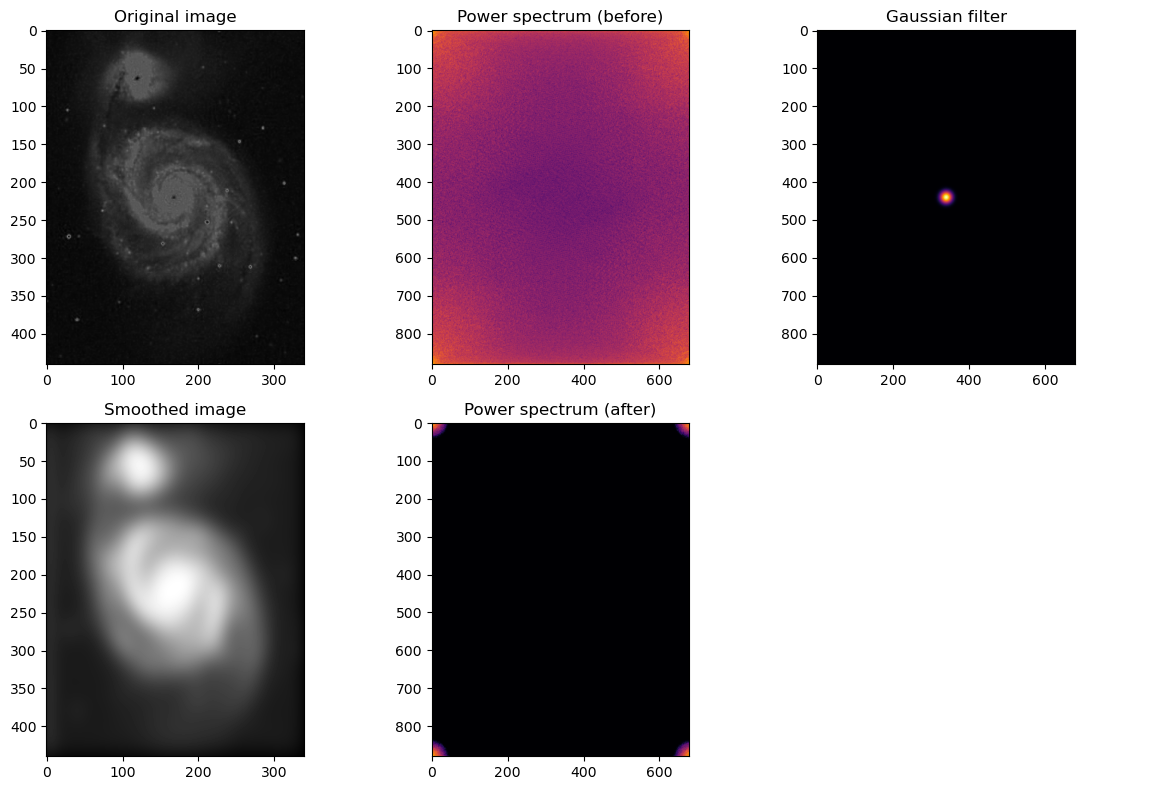

In [19]:
img_path = "galaxy.jpeg"
sigma = 10

img = load_image(img_path)
padded_img = pad_image(img)

padded_fft = compute_fft(padded_img)  
gaussian_filter = generate_gaussian_filter(padded_img.shape, sigma) 

filtered_fft = apply_filter(padded_fft, gaussian_filter)
smoothed_img = invert_fft(filtered_fft, img.shape, )

power_spectrum_before = np.abs(padded_fft)**2
power_spectrum_after = np.abs(filtered_fft)**2

plot_images(img, smoothed_img, power_spectrum_before, power_spectrum_after, gaussian_filter)

## 3 Solving PDEs with the DFT

To solve this exercxise, we need to solve two equations simultaneously for $B_x$ and $B_y$.

We are given two partial differential equations from Maxwell’s equations in the static case:

1. The **induction equation** (Ampère's Law, z-component), which relates the curl of the magnetic field to the current density:
$
\frac{\partial B_y}{\partial x} - \frac{\partial B_x}{\partial y} = j_z(x, y)
$

2. The **divergence-free condition** (Gauss’s Law for magnetism), which ensures there are no magnetic monopoles:
$
\frac{\partial B_x}{\partial x} + \frac{\partial B_y}{\partial y} = 0
$

We solve this system using Fourier transforms, which turn derivatives into simple multiplications in Fourier space. This makes the system algebraic and much easier to solve numerically. In Fourier space, we define the wave vector $\vec{k} = (k_x, k_y)$, and take the Fourier transforms of all fields. The equations become:

1. $i k_x \hat{B}_y - i k_y \hat{B}_x = \hat{j}_z $
2. $i k_x \hat{B}_x + i k_y \hat{B}_y = 0 $

We can write the system in the matrix form:
$\begin{bmatrix}
-ik_y & ik_x \\
ik_x & ik_y
\end{bmatrix}
\begin{bmatrix}
\hat{B}_x \\
\hat{B}_y
\end{bmatrix} = 
\begin{bmatrix}
\hat{j}_z \\
0
\end{bmatrix}
$

Solving this system for $(k_x, k_y) \neq (0, 0)$, we find an explicit expression for $\hat{B}_x$ and $\hat{B}_y$ in terms of $\hat{j}_z$:
$
\hat{B}_x = \frac{i k_y \hat{j}_z}{k_x^2 + k_y^2}, \quad
\hat{B}_y = -\frac{i k_x \hat{j}_z}{k_x^2 + k_y^2}
$

This solution automatically satisfies both the curl and divergence conditions. The denominator $k_x^2 + k_y^2$ ensures the correct scaling for each mode, analogous to solving the Poisson equation in Fourier space.

In code, we implement this using NumPy. We define a grid with spacing h, compute the Fourier-space wave numbers $k_x, k_y$ using `np.fft.fftfreq`, take the 2D FFT of the input current field $j_z(x, y)$, and then solve for $\hat{B}_x$ and $\hat{B}_y$ using the equations above. At the zero mode $(k_x, k_y) = (0, 0)$, we manually set the result to zero to avoid division by zero and because a constant magnetic field component is physically irrelevant in a periodic domain.

Finally, we apply the inverse FFT to obtain $B_x(x, y)$ and $B_y(x, y)$ in real space and visualize the resulting vector field using `plt.quiver`.

To represent a localized current source, we initialize $j_z$ to be zero everywhere except at one point in the center of the domain. To properly model a delta function in discrete space, the value at the source point is scaled by $1/h^2$, since the integral (sum) over a grid cell of size $h \times h$ should approximate a unit delta.

This approach results in a realistic simulation of the magnetic field generated by a point current, showing circular field lines around the source as expected from physical intuition.


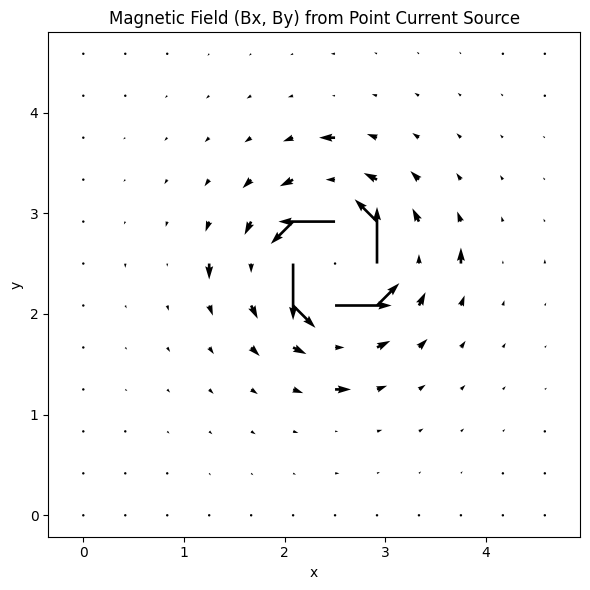

In [59]:

def magnetic_field_solver(jz, h):
    N = jz.shape[0]
    L = N * h  # total domain size

    # Wave numbers in Fourier space
    k = 2 * np.pi * np.fft.fftfreq(N, d=h)
    kx, ky = np.meshgrid(k, k, indexing='ij')

    # Fourier transform of current field
    jz_hat = np.fft.fft2(jz)

    # Avoid division by zero at k=0
    denom = kx**2 + ky**2
    denom[0, 0] = 1.0  # temporarily avoid divide-by-zero

    # Solve equations in Fourier space
    Bx_hat = 1j * ky * jz_hat / denom
    By_hat = -1j * kx * jz_hat / denom

    # Remove the mean (DC) component
    Bx_hat[0, 0] = 0.0
    By_hat[0, 0] = 0.0

    # Transform back to real space
    Bx = np.real(np.fft.ifft2(Bx_hat))
    By = np.real(np.fft.ifft2(By_hat))

    return Bx, By

# Simulation parameters
N = 12         # Grid size
h = 5.0 / N     # Step size
L = N * h       # Domain length

# Define grid and current source
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, N, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')

# Current: point source at center
jz = np.zeros((N, N))
jz[N//2, N//2] = 1.0 / h**2  # normalize for delta-function-like source

# Solve
Bx, By = magnetic_field_solver(jz, h)

# Plot the vector field
plt.figure(figsize=(6, 6))
plt.quiver(X, Y, Bx, By, scale=5)
plt.title("Magnetic Field (Bx, By) from Point Current Source")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [60]:
# other versions

In [23]:
# Grid size
N = 128
L = 2 * np.pi
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, N, endpoint=False)
X, Y = np.meshgrid(x, y)

# Define current jz(x, y): point source at center
jz = np.zeros((N, N))
jz[N // 2, N // 2] = 1.0  # delta-like source at the center

# Fourier frequencies
kx = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
ky = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)

# Fourier transform of the source
jz_hat = np.fft.fft2(jz)

# Avoid division by zero at k=0
K_squared = KX**2 + KY**2
K_squared[0, 0] = 1  # prevent division by zero

# Solve the system:
# (1) i kx By_hat - i ky Bx_hat = jz_hat
# (2) i kx Bx_hat + i ky By_hat = 0

# Express Bx_hat and By_hat in terms of jz_hat
Bx_hat = 1j * KY * jz_hat / K_squared
By_hat = -1j * KX * jz_hat / K_squared

Bx_hat[0, 0] = 0  # Remove mean (no monopole field)
By_hat[0, 0] = 0

# Transform back to real space
Bx = np.fft.ifft2(Bx_hat).real
By = np.fft.ifft2(By_hat).real


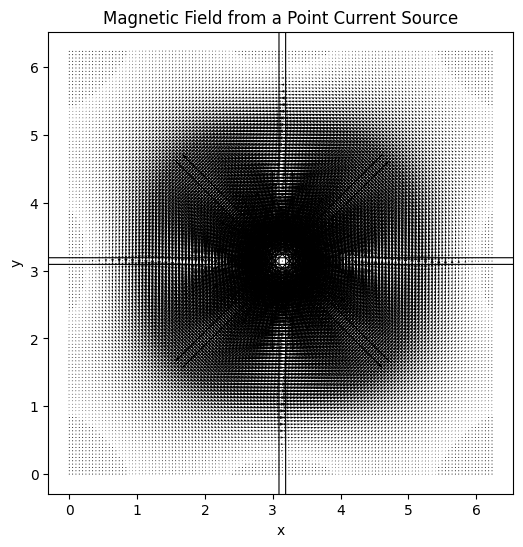

In [27]:
plt.figure(figsize=(6, 6))
plt.quiver(X, Y, Bx, By, scale=0.01, pivot='mid')
plt.title("Magnetic Field from a Point Current Source")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()


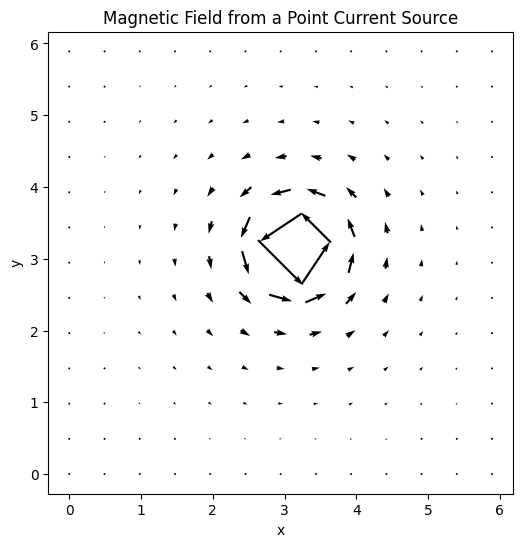

In [47]:
h = 10 # Adjust to reduce arrow density

plt.figure(figsize=(6, 6))
plt.quiver(X[::h, ::h], Y[::h, ::h],
           Bx[::h, ::h], By[::h, ::h],
           scale=0.01, pivot='mid')
plt.title("Magnetic Field from a Point Current Source")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()


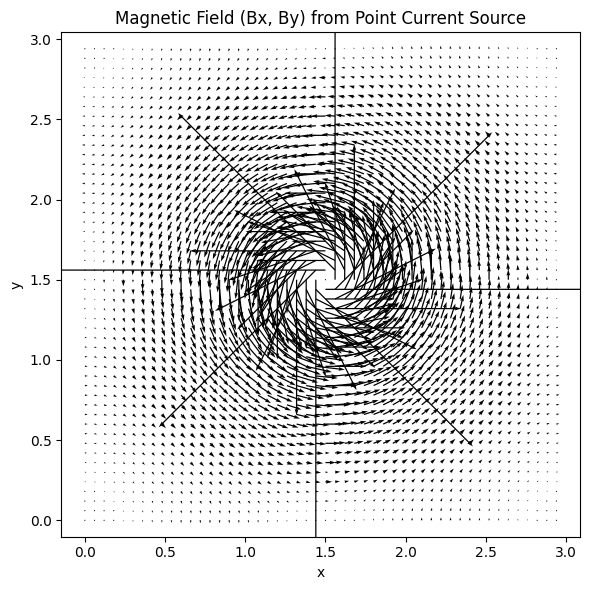

In [56]:
def magnetic_field_solver(jz, h):
    N = jz.shape[0]
    L = N * h  # total domain size

    # Wave numbers in Fourier space
    k = 2 * np.pi * np.fft.fftfreq(N, d=h)
    kx, ky = np.meshgrid(k, k, indexing='ij')

    # Fourier transform of current field
    jz_hat = np.fft.fft2(jz)

    # Avoid division by zero at k=0
    denom = kx**2 + ky**2
    denom[0, 0] = 1.0  # temporarily avoid divide-by-zero

    # Solve equations in Fourier space
    Bx_hat = 1j * ky * jz_hat / denom
    By_hat = -1j * kx * jz_hat / denom

    # Remove the mean (DC) component
    Bx_hat[0, 0] = 0.0
    By_hat[0, 0] = 0.0

    # Transform back to real space
    Bx = np.real(np.fft.ifft2(Bx_hat))
    By = np.real(np.fft.ifft2(By_hat))

    return Bx, By

# Simulation parameters
N = 50         # Grid size
h = 3.0/N      # Step size
L = N * h      # Domain length

# Define grid and current source
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, N, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')

# Current: point source at center
jz = np.zeros((N, N))
jz[N//2, N//2] = 1.0 / h**2  # normalize for delta-function-like source

# Solve
Bx, By = magnetic_field_solver(jz, h)

# Plot the vector field
plt.figure(figsize=(6, 6))
plt.quiver(X, Y, Bx, By, scale=5)
plt.title("Magnetic Field (Bx, By) from Point Current Source")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.tight_layout()
plt.show()

